## Deep Learning Approach

In [761]:
#import appropriate packages

import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
import numpy
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score as cvs
from sklearn.model_selection import StratifiedShuffleSplit
import dask.dataframe as dd
from scipy.stats import skew
from sklearn import preprocessing
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier

from tab2img.converter import Tab2Img

#deep learning
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.callbacks import EarlyStopping
import torch
from torch import nn
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.impute import SimpleImputer

## Data Load

In [762]:
#colet_deep_data = pd.DataFrame()
#temp = pd.read_csv(r'E:\Deakin\SIT724\Data Set\Data\COLET\To upload\colet_deep_learning_data.csv', iterator = True, chunksize = 1000)
#colet_deep_data = pd.concat(temp, ignore_index=True)

In [763]:
#print(colet_deep_data.shape[0])

In [764]:
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

#colet_deep_data.isnull().sum(axis=0)

In [765]:
# Identify number of entrires for each class/participant

#class balancing? 

# GAZE

In [766]:
#check other COLET dataframes
colet_gaze = pd.read_csv(r'E:\Deakin\SIT724\Data Set\Data\COLET\To upload\colet_gaze_concat.csv')


In [767]:
#remove missing values

colet_gaze = colet_gaze.dropna()

In [768]:
#reset this as we are working with the index 

colet_gaze = colet_gaze.reset_index()

In [769]:
## Testing below

Test the below: 

- get the rolling feature value for the window, and then this becomes its own feature 

- apply the rolling using the windows created 

- class imbalance 

In [770]:
#calculate the difference between the earliest and latest timestamp by participant and task

#colet_gaze['index_diff']= colet_gaze.reset_index().groupby(['file', 'task'])['index'].transform(lambda x: x.max() - x.min())

In [771]:
#colet_gaze['window_size'] = round(colet_gaze['index_diff']/6)

In [772]:
#if between min and min + window_size then 1

In [773]:
# Create a new field 'window' with overlapping windows
#colet_gaze['window'] = colet_gaze.groupby(['file', 'task'])['index'].transform(lambda x: pd.Series(range(1, len(x) - 1)).rolling(window=int(colet_gaze['window_size'].iloc[0]), min_periods=1).apply(lambda y: y.iloc[-1] if not y.empty else None))

In [774]:
# Define the window size
#window_size = 5

# Group by 'file' and 'task', and calculate the window based on the index
#colet_gaze['window'] = colet_gaze.groupby(['file', 'task']).apply(lambda x: pd.RangeIndex(start=1, stop=len(x)+1) + window_size).values


In [775]:
#colet_gaze[colet_gaze['file'] == 'Task1_Subject_9.xlsx']

import pandas as pd

# Assuming your DataFrame is named colet_gaze and contains 'index', 'file', and 'task' columns

# Define the window function
def get_window_number(index):
    group_size = 3
    window_size = 5

    if index % window_size == 0:
        return 1
    else:
        group_index = (index // window_size) * group_size
        if index >= group_index and index < group_index + window_size:
            return (index - group_index) // group_size + 1
        else:
            return None

# Group by 'file' and 'task' and create window columns
grouped = colet_gaze.groupby(['file', 'task'])

for group_name, group_data in grouped:
    for i in range(1, 6):  # Assuming 5 windows
        window_col = f'window_{i}_{group_name[0]}_{group_name[1]}'
        colet_gaze.loc[group_data.index, window_col] = group_data['index'].apply(lambda x: 1 if get_window_number(x) == i else 0)

colet_gaze

In [776]:
## Testing above 

In [777]:
#calculate the difference between the earliest and latest timestamp by participant and task

colet_gaze['timestamp_diff']= (colet_gaze.groupby(['file', 'task'])['gaze_timestamp'].transform('max')-
             colet_gaze.groupby(['file', 'task'])['gaze_timestamp'].transform('min'))

In [778]:
#create an even number of window sizes

#if we want to have a set window size use below
#colet_gaze['window_size'] = 50
#original approach, use below
#29/08/2024 - attempting 20 windows (from 15 windows)
colet_gaze['window_size'] = round(colet_gaze['timestamp_diff']/10)
# 1 window, use below
#colet_gaze['window_size'] = round(colet_gaze['timestamp_diff']/1)

In [779]:
# create a fixed window size

# 1 window
#max_category_n = 1
#original approach, use below
#29/08/2024 - attempting 20 windows (from 16 windows)
max_category_n = 11
#if setting a set window size, use below
#max_category_n = round(colet_gaze['timestamp_diff']/colet_gaze['window_size'] ).astype(int).max()

In [780]:
#include a 'min timestamp' for calculations below

colet_gaze['min_gaze_timestamp'] = colet_gaze.groupby(['file', 'task'])['gaze_timestamp'].transform('min')

In [781]:
# Define a function to apply the logic and assign categories
def assign_category(row):
    max_category = max_category_n
    for i in range(1, max_category + 1):
        lower_bound = row['min_gaze_timestamp'] + (row['window_size'] * (i - 1))
        upper_bound = row['min_gaze_timestamp'] + (row['window_size'] * i)
        if row['gaze_timestamp'] >= lower_bound and row['gaze_timestamp'] <= upper_bound:
            return i
    return None

# Apply the function to create the 'category' column
colet_gaze['category'] = colet_gaze.apply(assign_category, axis=1)

#print(colet_gaze)

In [782]:
colet_gaze

,index,gaze_timestamp,world_index,confidence,norm_pos_x,norm_pos_y,base_data,gaze_point_3d_x,gaze_point_3d_y,gaze_point_3d_z,...,eye_center1_3d_z,gaze_normal1_x,gaze_normal1_y,gaze_normal1_z,file,task,timestamp_diff,window_size,min_gaze_timestamp,category
0,0,5410.551715,0,0.999499,0.446264,0.846886,'5410.549631999999-0 5410.553797-1',-6.720630,-31.252881,80.700682,...,-21.600300,0.277597,-0.391313,0.877391,Task1_Subject_1.xlsx,1,33.656181,3.0,5410.551715,1.0
1,1,5410.555834,0,0.999653,0.446534,0.847007,'5410.557871999999-0 5410.553797-1',-6.690706,-31.298388,80.793260,...,-21.600300,0.277597,-0.391313,0.877391,Task1_Subject_1.xlsx,1,33.656181,3.0,5410.551715,1.0
2,2,5410.559774,0,0.999648,0.446660,0.846410,'5410.557871999999-0 5410.561675-1',-6.664575,-31.211650,80.708374,...,-21.600300,0.278049,-0.390575,0.877576,Task1_Subject_1.xlsx,1,33.656181,3.0,5410.551715,1.0
3,3,5410.563583,0,0.999656,0.446442,0.845542,'5410.565490999999-0 5410.561675-1',-6.689463,-31.118351,80.664979,...,-21.600300,0.278049,-0.390575,0.877576,Task1_Subject_1.xlsx,1,33.656181,3.0,5410.551715,1.0
4,4,5410.568291,0,0.999565,0.446472,0.845614,'5410.565490999999-0 5410.571091999999-1',-6.683464,-31.115105,80.640260,...,-21.600300,0.278153,-0.390681,0.877496,Task1_Subject_1.xlsx,1,33.656181,3.0,5410.551715,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1898156,2077501,222043.332706,272,0.999866,0.515607,0.439272,'222043.33090499998-0 222043.334508-1',3.434937,0.810220,101.123017,...,-21.524028,0.327293,-0.097566,0.939872,Task1_Subject_9.xlsx,4,6709.032149,671.0,222017.460451,1.0
1898157,2077502,222043.336530,273,0.999767,0.514888,0.438728,'222043.33855199997-0 222043.334508-1',3.305292,0.857062,100.751790,...,-21.524028,0.327293,-0.097566,0.939872,Task1_Subject_9.xlsx,4,6709.032149,671.0,222017.460451,1.0
1898158,2077503,222043.340519,273,0.999846,0.514192,0.439384,'222043.33855199997-0 222043.34248599998-1',3.213693,0.802417,101.432418,...,-21.524028,0.325053,-0.097289,0.940678,Task1_Subject_9.xlsx,4,6709.032149,671.0,222017.460451,1.0
1898159,2077504,222043.344584,273,0.999875,0.508943,0.436278,'222043.346681-0 222043.34248599998-1',2.293070,1.059562,98.765386,...,-21.524028,0.325053,-0.097289,0.940678,Task1_Subject_9.xlsx,4,6709.032149,671.0,222017.460451,1.0


# PUPIL

In [783]:
colet_pupil = pd.read_csv(r'E:\Deakin\SIT724\Data Set\Data\COLET\To upload\colet_pupil_concat.csv')
colet_pupil.isnull().sum(axis=0)

pupil_timestamp               781802
world_index                   781802
eye_id                        781802
confidence                    781802
norm_pos_x                    781802
norm_pos_y                    781802
diameter                      781802
method                        781802
ellipse_center_x              781802
ellipse_center_y              782207
ellipse_axis_a                782207
ellipse_axis_b                782207
ellipse_angle                 782207
diameter_3d                  2871989
model_confidence             2871989
model_id                     2872024
sphere_center_x              2872024
sphere_center_y              2872024
sphere_center_z              2872024
sphere_radius                2872024
circle_3d_center_x           2872024
circle_3d_center_y           2883238
circle_3d_center_z           2883238
circle_3d_normal_x           2883238
circle_3d_normal_y           2883238
circle_3d_normal_z           2883238
circle_3d_radius             2883238
t

In [784]:
#drop missing values
colet_pupil = colet_pupil.dropna()

In [785]:
#calculate the difference between the earliest and latest timestamp by participant and task

colet_pupil['timestamp_diff']= (colet_pupil.groupby(['file', 'task'])['pupil_timestamp'].transform('max')-
             colet_pupil.groupby(['file', 'task'])['pupil_timestamp'].transform('min'))

In [786]:


#if we set the window size, use below to create an even number of window sizes
#colet_pupil['window_size'] = 50

#original approach below
#29/08/2024 - attempting 20 windows (from 15 windows)
colet_pupil['window_size'] = round(colet_pupil['timestamp_diff']/10)
# 1 window
#colet_pupil['window_size'] = round(colet_pupil['timestamp_diff']/1)

In [787]:
# create a fixed window size

#1 window
#max_category_n = 1

#original approach
#29/08/2024 - attempting 20 windows (from 16 windows)
max_category_n = 11

#if we set the window size, use below
#max_category_n = round(colet_pupil['timestamp_diff']/colet_pupil['window_size']).astype(int).max()

In [788]:
#include a 'min timestamp' for calculations below

colet_pupil['min_pupil_timestamp'] = colet_pupil.groupby(['file', 'task'])['pupil_timestamp'].transform('min')

In [789]:
# Define a function to apply the logic and assign categories
def assign_category(row):
    max_category = max_category_n
    for i in range(1, max_category + 1):
        lower_bound = row['min_pupil_timestamp'] + (row['window_size'] * (i - 1))
        upper_bound = row['min_pupil_timestamp'] + (row['window_size'] * i)
        if row['pupil_timestamp'] >= lower_bound and row['pupil_timestamp'] <= upper_bound:
            return i
    return None

# Apply the function to create the 'category' column
colet_pupil['category'] = colet_pupil.apply(assign_category, axis=1)



In [790]:
#check if it's applyign correctly

print(colet_pupil[colet_pupil['file'] == 'Task1_Subject_1.xlsx']['category'].unique())

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. nan]


# BLINK

In [791]:
colet_blink = pd.read_csv(r'E:\Deakin\SIT724\Data Set\Data\COLET\To upload\colet_blink_concat.csv')
colet_blink.isnull().sum(axis=0)

ID                   0
start_timestamp      0
duration             0
end_timestamp        0
start_frame_index    0
index                0
end_frame_index      0
confidence           0
filter_response      0
base_Data            0
file                 0
task                 0
dtype: int64

In [792]:
#calculate the difference between the earliest and latest timestamp by participant and task

colet_blink['timestamp_diff']= (colet_blink.groupby(['file', 'task'])['start_timestamp'].transform('max')-
             colet_blink.groupby(['file', 'task'])['start_timestamp'].transform('min'))

In [793]:
#create an even number of window sizes

#1 window
#colet_blink['window_size'] = 1

#if we set a window size use below
#colet_blink['window_size'] = 50

#opriginal approach use below
#29/08/2024 - attempting 20 windows (from 16 windows)
colet_blink['window_size'] = round(colet_blink['timestamp_diff']/10)

In [794]:
#create a fixed window size

#1 window
#max_category_n = 1

#if setting window size use below
#max_category_n = round(colet_blink['timestamp_diff']/colet_blink['window_size']).astype(int).max()

#original approach
max_category_n = 11

In [795]:
#include a 'min timestamp' for calculations below

colet_blink['min_blink_timestamp'] = colet_blink.groupby(['file', 'task'])['start_timestamp'].transform('min')

In [796]:
# Define a function to apply the logic and assign categories
def assign_category(row):
    max_category = max_category_n
    for i in range(1, max_category + 1):
        lower_bound = row['min_blink_timestamp'] + (row['window_size'] * (i - 1))
        upper_bound = row['min_blink_timestamp'] + (row['window_size'] * i)
        if row['start_timestamp'] >= lower_bound and row['start_timestamp'] <= upper_bound:
            return i
    return None

# Apply the function to create the 'category' column
colet_blink['category'] = colet_blink.apply(assign_category, axis=1)



In [797]:
colet_blink

,ID,start_timestamp,duration,end_timestamp,start_frame_index,index,end_frame_index,confidence,filter_response,base_Data,file,task,timestamp_diff,window_size,min_blink_timestamp,category
0,1,5437.625617,0.236131,5437.861748,37.0,40.0,44.0,0.703872,'0.5068225043614704 0.5512669488059149 0.59571...,'5437.625617 5437.629564 5437.633621 5437.6378...,Task1_Subject_1.xlsx,1,6.535944,1.0,5437.625617,1.0
1,2,5444.161561,0.180073,5444.341634,231.0,233.0,236.0,0.553669,'0.5048782729116744 0.5493227173561188 0.59287...,'5444.161561 5444.165642 5444.169793 5444.1755...,Task1_Subject_1.xlsx,1,6.535944,1.0,5437.625617,7.0
2,1,471465.723115,0.252434,471465.975549,21.0,24.0,28.0,0.659305,'0.53595171449361 0.5822480107899064 0.6061400...,'471465.723115 471465.731078 471465.7310899999...,Task1_Subject_10.xlsx,1,0.000000,0.0,471465.723115,1.0
3,1,8419.904790,0.203903,8420.108693,16.0,19.0,22.0,0.671161,'0.5366363953239319 0.5810808397683763 0.62552...,'8419.90479 8419.908641 8419.912594000001 8419...,Task1_Subject_11.xlsx,1,41.611652,4.0,8419.904790,1.0
4,2,8422.874139,0.166438,8423.040577,105.0,107.0,110.0,0.541905,'0.5358719345469952 0.5803163789914397 0.62476...,'8422.874139000001 8422.877731 8422.8813280000...,Task1_Subject_11.xlsx,1,41.611652,4.0,8419.904790,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1711,3,228712.420777,0.168113,228712.588890,287.0,289.0,292.0,0.554141,'0.5037201405857574 0.5500164368820537 0.59631...,'228712.420777 228712.420938 228712.428812 228...,Task1_Subject_9.xlsx,4,36.144147,4.0,228685.525146,7.0
1712,1,228718.560785,0.132246,228718.693031,23.0,25.0,27.0,0.417348,'0.531989059581162 0.5406546851960738 0.548623...,'228718.56078499998 228718.56080099999 228718....,Task1_Subject_9.xlsx,4,36.144147,4.0,228685.525146,9.0
1713,2,228719.464743,0.168152,228719.632895,50.0,52.0,55.0,0.534863,'0.5009343921762599 0.5472306884725565 0.57108...,'228719.464743 228719.46478399998 228719.47291...,Task1_Subject_9.xlsx,4,36.144147,4.0,228685.525146,9.0
1714,3,228719.940827,0.164094,228720.104921,64.0,66.0,69.0,0.507862,'0.5114266499435292 0.5577229462398255 0.58064...,'228719.94082699998 228719.94083399998 228719....,Task1_Subject_9.xlsx,4,36.144147,4.0,228685.525146,9.0


# ANNOTATION

In [798]:
colet_annot = pd.read_csv(r'E:\Deakin\SIT724\Data Set\Data\COLET\To upload\colet_annot_concat.csv')
colet_annot.isnull().sum(axis=0)

mental_1         0
physical_1       0
temporal_1       0
perforamnce_1    0
effort_1         0
frustation_1     0
mean_1           0
file             0
task             0
dtype: int64

In [799]:
#only really need mean_1 for the DV
colet_annot = colet_annot[['file', 'task', 'mean_1']]

### no need to do any additional work on annotation, but do need to merge it to the dataframes at the end

# Additional features to allow for aggregation by windows

# Gaze features

## Fixations and Saccades

In [800]:
colet_gaze

,index,gaze_timestamp,world_index,confidence,norm_pos_x,norm_pos_y,base_data,gaze_point_3d_x,gaze_point_3d_y,gaze_point_3d_z,...,eye_center1_3d_z,gaze_normal1_x,gaze_normal1_y,gaze_normal1_z,file,task,timestamp_diff,window_size,min_gaze_timestamp,category
0,0,5410.551715,0,0.999499,0.446264,0.846886,'5410.549631999999-0 5410.553797-1',-6.720630,-31.252881,80.700682,...,-21.600300,0.277597,-0.391313,0.877391,Task1_Subject_1.xlsx,1,33.656181,3.0,5410.551715,1.0
1,1,5410.555834,0,0.999653,0.446534,0.847007,'5410.557871999999-0 5410.553797-1',-6.690706,-31.298388,80.793260,...,-21.600300,0.277597,-0.391313,0.877391,Task1_Subject_1.xlsx,1,33.656181,3.0,5410.551715,1.0
2,2,5410.559774,0,0.999648,0.446660,0.846410,'5410.557871999999-0 5410.561675-1',-6.664575,-31.211650,80.708374,...,-21.600300,0.278049,-0.390575,0.877576,Task1_Subject_1.xlsx,1,33.656181,3.0,5410.551715,1.0
3,3,5410.563583,0,0.999656,0.446442,0.845542,'5410.565490999999-0 5410.561675-1',-6.689463,-31.118351,80.664979,...,-21.600300,0.278049,-0.390575,0.877576,Task1_Subject_1.xlsx,1,33.656181,3.0,5410.551715,1.0
4,4,5410.568291,0,0.999565,0.446472,0.845614,'5410.565490999999-0 5410.571091999999-1',-6.683464,-31.115105,80.640260,...,-21.600300,0.278153,-0.390681,0.877496,Task1_Subject_1.xlsx,1,33.656181,3.0,5410.551715,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1898156,2077501,222043.332706,272,0.999866,0.515607,0.439272,'222043.33090499998-0 222043.334508-1',3.434937,0.810220,101.123017,...,-21.524028,0.327293,-0.097566,0.939872,Task1_Subject_9.xlsx,4,6709.032149,671.0,222017.460451,1.0
1898157,2077502,222043.336530,273,0.999767,0.514888,0.438728,'222043.33855199997-0 222043.334508-1',3.305292,0.857062,100.751790,...,-21.524028,0.327293,-0.097566,0.939872,Task1_Subject_9.xlsx,4,6709.032149,671.0,222017.460451,1.0
1898158,2077503,222043.340519,273,0.999846,0.514192,0.439384,'222043.33855199997-0 222043.34248599998-1',3.213693,0.802417,101.432418,...,-21.524028,0.325053,-0.097289,0.940678,Task1_Subject_9.xlsx,4,6709.032149,671.0,222017.460451,1.0
1898159,2077504,222043.344584,273,0.999875,0.508943,0.436278,'222043.346681-0 222043.34248599998-1',2.293070,1.059562,98.765386,...,-21.524028,0.325053,-0.097289,0.940678,Task1_Subject_9.xlsx,4,6709.032149,671.0,222017.460451,1.0


In [801]:
#get the difference between the previous value for each row

colet_gaze.sort_values(['file', 'gaze_timestamp', 'task', 'category'], inplace=True)
colet_gaze['gaze_diff'] = colet_gaze.groupby(['file', 'task', 'category'])['gaze_timestamp'].diff()
colet_gaze['x_diff'] = colet_gaze.groupby(['file', 'task', 'category'])['gaze_point_3d_x'].diff()
colet_gaze['y_diff'] = colet_gaze.groupby(['file', 'task', 'category'])['gaze_point_3d_y'].diff()
colet_gaze['z_diff'] = colet_gaze.groupby(['file', 'task', 'category'])['gaze_point_3d_z'].diff()

In [802]:
#square x, y and z

colet_gaze['x_diff^2'] = colet_gaze['x_diff']**2
colet_gaze['y_diff^2'] = colet_gaze['y_diff']**2
colet_gaze['z_diff^2'] = colet_gaze['z_diff']**2

In [803]:
#sum x y and z
column_names = ['x_diff^2','y_diff^2','z_diff^2']

colet_gaze['sum']= colet_gaze[column_names].sum(axis=1)

In [804]:
#take sqrt of this value

colet_gaze['sqrt']= np.sqrt(colet_gaze['sum'])

In [805]:
#divide by displacement to obtain velocity

colet_gaze['velocity'] = colet_gaze['gaze_diff'] / colet_gaze['sqrt']

In [806]:
# skewness of velocity

colet_gaze['skew_velocity'] = colet_gaze.groupby(['file', 'task', 'category'])['velocity'].transform(lambda x: x.skew())

# kurtosis of velocity

colet_gaze['kurtosis_velocity'] = colet_gaze.groupby(['file', 'task', 'category'])['velocity'].transform(lambda x: x.kurtosis())

In [807]:
# skewness of duration

colet_gaze['skew_gaze_duration'] = colet_gaze.groupby(['file', 'task', 'category'])['gaze_diff'].transform(lambda x: x.skew())

#kurtosis of duration

colet_gaze['kurtosis_gaze_duration'] = colet_gaze.groupby(['file', 'task', 'category'])['gaze_diff'].transform(lambda x: x.kurtosis())

In [808]:
#fixation flag

colet_gaze['fixation_flag'] = np.where((colet_gaze['velocity'] < 0.45) & (colet_gaze['gaze_diff']) > 0.55, 1, 0)

In [809]:
#grouping fixations (as the authors did the same thing)

colet_gaze['fix_group'] = colet_gaze.groupby(['file', 'task', 'category'])['fixation_flag'].diff().abs().cumsum().fillna(0).astype(int) + 1

In [810]:
#counting fixations 1 time! 

colet_gaze['fixations_count'] = colet_gaze.groupby(['file', 'task', 'category'])['fix_group'].transform('nunique')

In [811]:
#fixations per second

colet_gaze['fix_per_sec'] = colet_gaze['fixations_count'] / colet_gaze['timestamp_diff']

In [812]:
#saccade flag
colet_gaze['saccade_flag'] = np.where((colet_gaze['velocity'] > 0.45) & (colet_gaze['gaze_diff']) < 0.55, 1, 0)

In [813]:
#saccades per second
colet_gaze['saccade_sum'] = colet_gaze.groupby(['file', 'task', 'category'])['saccade_flag'].transform('sum')

colet_gaze['sac_per_sec'] = colet_gaze['saccade_sum'] / colet_gaze['timestamp_diff']

In [814]:
#max eye movement velocity
colet_gaze['max_movement_velocity'] = colet_gaze.groupby(['file', 'task', 'category'])['velocity'].transform('max')

#min eye movement velocity
colet_gaze['min_movement_velocity'] = colet_gaze.groupby(['file', 'task', 'category'])['velocity'].transform('min')

In [815]:
#skewness kurtosis can't work on nulls
colet_gaze = colet_gaze.dropna()

#skewness max velocity

colet_gaze['skew_max_velocity'] = colet_gaze.groupby(['task', 'category'])['max_movement_velocity'].transform(lambda x: x.skew())

#skewness max kurtosis

colet_gaze['kurtosis_max_velocity'] = colet_gaze.groupby(['task', 'category'])['max_movement_velocity'].transform(lambda x: x.kurtosis())

#skewness min velocity

colet_gaze['skew_min_velocity'] = colet_gaze.groupby(['task', 'category'])['min_movement_velocity'].transform(lambda x: x.skew())

#kurtosis min velocity

colet_gaze['kurtosis_min_velocity'] = colet_gaze.groupby(['task', 'category'])['min_movement_velocity'].transform(lambda x: x.kurtosis())

In [816]:
colet_gaze

,index,gaze_timestamp,world_index,confidence,norm_pos_x,norm_pos_y,base_data,gaze_point_3d_x,gaze_point_3d_y,gaze_point_3d_z,...,fix_per_sec,saccade_flag,saccade_sum,sac_per_sec,max_movement_velocity,min_movement_velocity,skew_max_velocity,kurtosis_max_velocity,skew_min_velocity,kurtosis_min_velocity
415884,424633,4659.171724,0,0.999934,0.467982,0.841412,'4659.173514-0 4659.169934-1',-3.374369,-28.127372,73.947970,...,0.140427,1,735.0,25.803395,0.851172,0.000456,6.079923,36.079258,1.634429,2.409062
415885,424634,4659.175874,0,0.999912,0.467992,0.841952,'4659.173514-0 4659.178234999999-1',-3.372870,-28.163546,73.927925,...,0.140427,1,735.0,25.803395,0.851172,0.000456,6.079923,36.079258,1.634429,2.409062
415886,424635,4659.179746,0,0.999956,0.467042,0.841566,'4659.181258-0 4659.178234999999-1',-3.479495,-28.023615,73.637258,...,0.140427,1,735.0,25.803395,0.851172,0.000456,6.079923,36.079258,1.634429,2.409062
415887,424636,4659.183226,0,0.999976,0.467126,0.841238,'4659.181258-0 4659.185194-1',-3.466174,-27.978763,73.589596,...,0.140427,1,735.0,25.803395,0.851172,0.000456,6.079923,36.079258,1.634429,2.409062
415888,424637,4659.188242,0,0.999907,0.468032,0.841165,'4659.19129-0 4659.185194-1',-3.364733,-28.081880,73.881275,...,0.140427,1,735.0,25.803395,0.851172,0.000456,6.079923,36.079258,1.634429,2.409062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1892507,2071206,228726.473798,258,0.999584,0.551797,0.533421,'228726.46905299998-0 228726.47854299998-1',12.744060,-10.693456,137.204654,...,0.000894,1,9955.0,1.483821,1.473069,0.000050,6.097798,35.540866,1.187741,0.898284
1892508,2071207,228726.478479,259,0.999399,0.551946,0.534139,'228726.478416-0 228726.47854299998-1',12.789399,-10.793831,137.326583,...,0.000894,1,9955.0,1.483821,1.473069,0.000050,6.097798,35.540866,1.187741,0.898284
1892509,2071208,228726.484354,259,0.999110,0.552357,0.533331,'228726.490165-0 228726.47854299998-1',12.919169,-10.724065,137.732324,...,0.000894,1,9955.0,1.483821,1.473069,0.000050,6.097798,35.540866,1.187741,0.898284
1892510,2071209,228726.489828,259,0.998905,0.550968,0.537481,'228726.490165-0 228726.489491-1',12.807938,-11.423754,139.895061,...,0.000894,1,9955.0,1.483821,1.473069,0.000050,6.097798,35.540866,1.187741,0.898284


In [817]:
#select columns of interest 
colet_gaze = colet_gaze[['file', 'task', 'category', 'fixations_count', 'sac_per_sec', 'fix_per_sec', 'max_movement_velocity', 'min_movement_velocity', 'saccade_sum'
                         , 'skew_max_velocity', 'kurtosis_max_velocity', 'skew_min_velocity', 'kurtosis_min_velocity'
                        ]]

In [818]:
#remove duplicates
colet_gaze = colet_gaze.drop_duplicates()

In [819]:
#the max values are resulting in infinite values, instead replacing these infinite values with the next highest max value

# Replace 'inf' values with the maximum 'max_movement_velocity' grouped by 'file', 'task', and 'category'
colet_gaze['max_movement_velocity'] = colet_gaze['max_movement_velocity'].replace([np.inf], np.nan)  # Replace 'inf' with nan temporarily

max_values = colet_gaze.groupby(['file', 'task', 'category'])['max_movement_velocity'].transform('max')
colet_gaze['max_movement_velocity'] = colet_gaze['max_movement_velocity'].fillna(max_values)  # Fill nan values with group max

In [820]:
colet_gaze.to_csv('colet_gaze_features.csv', index = False)

In [821]:
colet_gaze

,file,task,category,fixations_count,sac_per_sec,fix_per_sec,max_movement_velocity,min_movement_velocity,saccade_sum,skew_max_velocity,kurtosis_max_velocity,skew_min_velocity,kurtosis_min_velocity
415884,Task1_Subject_1.xlsx,2,1.0,4.0,25.803395,0.140427,0.851172,0.000456,735.0,6.079923,36.079258,1.634429,2.409062
416620,Task1_Subject_1.xlsx,2,2.0,6.0,23.907635,0.210640,0.743421,0.000314,681.0,1.467354,1.642482,1.458411,2.007684
417303,Task1_Subject_1.xlsx,2,3.0,6.0,24.469342,0.210640,0.841023,0.000288,697.0,1.838347,2.552079,1.096479,1.213320
418002,Task1_Subject_1.xlsx,2,4.0,6.0,26.049141,0.210640,0.465755,0.000444,742.0,1.416174,1.532845,1.148740,0.744324
418746,Task1_Subject_1.xlsx,2,5.0,4.0,24.715088,0.140427,0.837942,0.000494,704.0,6.349576,38.891437,3.765108,13.791689
...,...,...,...,...,...,...,...,...,...,...,...,...,...
725346,Task1_Subject_9.xlsx,2,8.0,2.0,21.861982,0.088331,0.179880,0.000135,495.0,2.283616,7.414347,1.097262,0.867942
725841,Task1_Subject_9.xlsx,2,9.0,2.0,19.521204,0.088331,0.097449,0.000141,442.0,1.856360,2.590684,1.466232,1.951784
726283,Task1_Subject_9.xlsx,2,10.0,2.0,21.861982,0.088331,0.113996,0.000258,495.0,1.039089,0.313180,15.171001,328.532033
726778,Task1_Subject_9.xlsx,2,11.0,2.0,21.729485,0.088331,0.262327,0.000148,492.0,1.196547,0.419859,2.645205,20.537798


# Pupil Features

## Pupil size

In [822]:
#avg diameter, max diameter, min diameter

#avg diameter
colet_pupil['avg_pupil_diameter'] = colet_pupil.groupby(['file', 'task', 'category'])['diameter'].transform('mean')

#max diameter
colet_pupil['max_pupil_diameter'] = colet_pupil.groupby(['file', 'task', 'category'])['diameter'].transform('max')

#min diameter
colet_pupil['min_pupil_diameter'] = colet_pupil.groupby(['file', 'task', 'category'])['diameter'].transform('min')

In [823]:
#skewness kurtosis can't work on nulls
colet_pupil = colet_pupil.dropna()

#skewness min diameter

colet_pupil['skew_min_pupil_diameter'] = colet_pupil.groupby(['task', 'category'])['min_pupil_diameter'].transform(lambda x: x.skew())

#kurtosis min diameter

colet_pupil['kurtosis_min_pupil_diamaeter'] = colet_pupil.groupby(['task', 'category'])['min_pupil_diameter'].transform(lambda x: x.kurtosis())

#skewness max diameter

colet_pupil['skew_max_pupil_diameter'] = colet_pupil.groupby([ 'task', 'category'])['max_pupil_diameter'].transform(lambda x: x.skew())

#kurtosis max diameter

colet_pupil['kurtosis_max_pupil_diamaeter'] = colet_pupil.groupby(['task', 'category'])['max_pupil_diameter'].transform(lambda x: x.kurtosis())


In [824]:
#select appropriate columns

colet_pupil = colet_pupil[['file', 'task', 'category', 'avg_pupil_diameter', 'max_pupil_diameter', 'min_pupil_diameter'
                           , 'skew_min_pupil_diameter', 'kurtosis_min_pupil_diamaeter', 'skew_max_pupil_diameter', 'kurtosis_max_pupil_diamaeter' 
                          ]]

In [825]:
#remove duplicate rows as we have aggreated these already

colet_pupil = colet_pupil.drop_duplicates()

In [826]:
colet_pupil.to_csv('colet_pupil_features.csv', index = False)

# Blink Features

In [827]:
#identify length of blink by using the timestamps
colet_blink['blink_duration'] = colet_blink['end_timestamp'] - colet_blink['start_timestamp']

In [828]:
#avg duration
colet_blink['avg_blink_duration'] = colet_blink.groupby(['file', 'task', 'category'])['blink_duration'].transform('mean')

#max duration
colet_blink['max_blink_duration'] = colet_blink.groupby(['file', 'task', 'category'])['blink_duration'].transform('max')

#min duration
colet_blink['min_blink_duration'] = colet_blink.groupby(['file', 'task', 'category'])['blink_duration'].transform('min')

In [829]:
#skewness kurtosis can't work on nulls
colet_blink = colet_blink.dropna()


#skewness min duration

colet_blink['skew_min_blink_duration'] = colet_blink.groupby(['task', 'category'])['min_blink_duration'].transform(lambda x: x.skew())

#kurtosis min duration

colet_blink['kurtosis_min_blink_duration'] = colet_blink.groupby(['task', 'category'])['min_blink_duration'].transform(lambda x: x.kurtosis())

#skewness max duration

colet_blink['skew_max_blink_duration'] = colet_blink.groupby(['task', 'category'])['max_blink_duration'].transform(lambda x: x.skew())

#kurtosis max duration

colet_blink['kurtosis_max_blink_duration'] = colet_blink.groupby(['task', 'category'])['max_blink_duration'].transform(lambda x: x.kurtosis())

In [830]:
colet_blink = colet_blink[['file', 'task', 'category', 'avg_blink_duration', 'max_blink_duration', 'min_blink_duration'
                           , 'skew_min_blink_duration', 'kurtosis_min_blink_duration', 'skew_max_blink_duration', 'kurtosis_max_blink_duration'
                          ]]

In [831]:
colet_blink = colet_blink.drop_duplicates()

In [832]:
colet_blink.to_csv('colet_blink_features.csv', index = False)

# Merge dataframes into one

In [833]:
#gaze and pupil
df1 = pd.merge(colet_gaze, colet_pupil, how='outer', on=['file', 'task', 'category'])

#gaze+pupil and blink
df2 = pd.merge(df1, colet_blink, how='outer', on=['file', 'task', 'category'])

#adding on the annotations
colet_final_df = pd.merge(df2, colet_annot, how = 'outer', on = ['file', 'task'])

del df2
del df1

In [834]:
colet_final_df.to_csv('colet_final_features.csv', index = False)

In [835]:
colet_final_df

,file,task,category,fixations_count,sac_per_sec,fix_per_sec,max_movement_velocity,min_movement_velocity,saccade_sum,skew_max_velocity,...,skew_max_pupil_diameter,kurtosis_max_pupil_diamaeter,avg_blink_duration,max_blink_duration,min_blink_duration,skew_min_blink_duration,kurtosis_min_blink_duration,skew_max_blink_duration,kurtosis_max_blink_duration,mean_1
0,Task1_Subject_1.xlsx,1,1.0,6.0,21.779060,0.178273,2.352442,0.000157,733.0,3.325669,...,0.719396,-0.384444,0.236131,0.236131,0.236131,2.145545,5.002551,1.928698,3.421452,15.0
1,Task1_Subject_1.xlsx,1,2.0,4.0,21.897909,0.118849,0.467896,0.000404,737.0,1.961000,...,0.666892,-0.510506,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0
2,Task1_Subject_1.xlsx,1,3.0,6.0,17.411363,0.178273,0.956278,0.000429,586.0,1.154201,...,0.772436,0.416134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0
3,Task1_Subject_1.xlsx,1,4.0,8.0,22.046470,0.237698,1.641238,0.000416,742.0,3.765106,...,0.948704,0.621073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0
4,Task1_Subject_1.xlsx,1,5.0,6.0,20.798557,0.178273,0.989723,0.000298,700.0,2.241756,...,1.016077,1.075297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864,Task1_Subject_9.xlsx,4,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.243776,-0.387015,0.179911,0.191709,0.168113,3.811199,15.554191,2.207237,4.981854,74.2
1865,Task1_Subject_9.xlsx,4,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.306634,9.095236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.2
1866,Task1_Subject_9.xlsx,4,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.210608,-1.238284,0.154831,0.168152,0.132246,5.875827,39.974439,1.484688,1.286975,74.2
1867,Task1_Subject_9.xlsx,4,10.0,6.0,1.483821,0.000894,1.473069,0.000050,9955.0,6.097798,...,2.919857,8.462143,0.200183,0.200183,0.200183,6.928457,53.186655,1.756720,1.425096,74.2


In [836]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print(colet_final_df.columns.tolist())

['file', 'task', 'category', 'fixations_count', 'sac_per_sec', 'fix_per_sec', 'max_movement_velocity', 'min_movement_velocity', 'saccade_sum', 'skew_max_velocity', 'kurtosis_max_velocity', 'skew_min_velocity', 'kurtosis_min_velocity', 'avg_pupil_diameter', 'max_pupil_diameter', 'min_pupil_diameter', 'skew_min_pupil_diameter', 'kurtosis_min_pupil_diamaeter', 'skew_max_pupil_diameter', 'kurtosis_max_pupil_diamaeter', 'avg_blink_duration', 'max_blink_duration', 'min_blink_duration', 'skew_min_blink_duration', 'kurtosis_min_blink_duration', 'skew_max_blink_duration', 'kurtosis_max_blink_duration', 'mean_1']


In [837]:
# Reset display options to default
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

# Feature Analysis

## creating multiclass target variables

In [838]:
#converting the mean_1 feature into a multiclass target variable for analysis

#01/09/2024 changed classes from 1, 2, 3 to 0, 1, 2 for XGB classifier 

bins = [0, 29, 49, 100]
# labels = ['0', '1', '2']
labels = [0, 1, 2]
colet_final_df['mean_1'] = pd.cut(colet_final_df['mean_1'], bins, labels=labels)
colet_final_df

,file,task,category,fixations_count,sac_per_sec,fix_per_sec,max_movement_velocity,min_movement_velocity,saccade_sum,skew_max_velocity,...,skew_max_pupil_diameter,kurtosis_max_pupil_diamaeter,avg_blink_duration,max_blink_duration,min_blink_duration,skew_min_blink_duration,kurtosis_min_blink_duration,skew_max_blink_duration,kurtosis_max_blink_duration,mean_1
0,Task1_Subject_1.xlsx,1,1.0,6.0,21.779060,0.178273,2.352442,0.000157,733.0,3.325669,...,0.719396,-0.384444,0.236131,0.236131,0.236131,2.145545,5.002551,1.928698,3.421452,0
1,Task1_Subject_1.xlsx,1,2.0,4.0,21.897909,0.118849,0.467896,0.000404,737.0,1.961000,...,0.666892,-0.510506,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,Task1_Subject_1.xlsx,1,3.0,6.0,17.411363,0.178273,0.956278,0.000429,586.0,1.154201,...,0.772436,0.416134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,Task1_Subject_1.xlsx,1,4.0,8.0,22.046470,0.237698,1.641238,0.000416,742.0,3.765106,...,0.948704,0.621073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,Task1_Subject_1.xlsx,1,5.0,6.0,20.798557,0.178273,0.989723,0.000298,700.0,2.241756,...,1.016077,1.075297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864,Task1_Subject_9.xlsx,4,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.243776,-0.387015,0.179911,0.191709,0.168113,3.811199,15.554191,2.207237,4.981854,2
1865,Task1_Subject_9.xlsx,4,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.306634,9.095236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1866,Task1_Subject_9.xlsx,4,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.210608,-1.238284,0.154831,0.168152,0.132246,5.875827,39.974439,1.484688,1.286975,2
1867,Task1_Subject_9.xlsx,4,10.0,6.0,1.483821,0.000894,1.473069,0.000050,9955.0,6.097798,...,2.919857,8.462143,0.200183,0.200183,0.200183,6.928457,53.186655,1.756720,1.425096,2


In [839]:
# List of columns to exclude from filling missing values with mean
exclude_cols = ['file', 'task', 'category']  # Add the columns you want to exclude from filling NaN values

# Identify numeric columns to fill missing values with mean
numeric_cols = colet_final_df.select_dtypes(include=['number']).columns

# Iterate through each numeric column except the excluded columns
for col in numeric_cols:
    if col not in exclude_cols:
        colet_final_df[col] = colet_final_df[col].fillna(colet_final_df.groupby('file')[col].transform('mean'))

#filling missing values - can't do it over the whole dataframe as it tries to fill other fields! Only grouping by task, as we have already aggregated

colet_final_df['avg_blink_duration'] = colet_final_df['avg_blink_duration'].fillna(colet_final_df.groupby('file')['avg_blink_duration'].transform('mean'))
colet_final_df['sac_per_sec'] = colet_final_df['sac_per_sec'].fillna(colet_final_df.groupby('file')['sac_per_sec'].transform('mean'))
colet_final_df['fix_per_sec'] = colet_final_df['fix_per_sec'].fillna(colet_final_df.groupby('file')['fix_per_sec'].transform('mean'))
colet_final_df['max_movement_velocity'] = colet_final_df['max_movement_velocity'].fillna(colet_final_df.groupby('file')['max_movement_velocity'].transform('mean'))
colet_final_df['min_movement_velocity'] = colet_final_df['min_movement_velocity'].fillna(colet_final_df.groupby('file')['min_movement_velocity'].transform('mean'))
colet_final_df['avg_blink_duration'] = colet_final_df['avg_blink_duration'].fillna(colet_final_df.groupby('file')['avg_blink_duration'].transform('mean'))
colet_final_df['max_blink_duration'] = colet_final_df['max_blink_duration'].fillna(colet_final_df.groupby('file')['max_blink_duration'].transform('mean'))
colet_final_df['skew_min_blink_duration'] = colet_final_df['skew_min_blink_duration'].fillna(colet_final_df.groupby('file')['skew_min_blink_duration'].transform('mean'))
colet_final_df['skew_max_blink_duration'] = colet_final_df['skew_max_blink_duration'].fillna(colet_final_df.groupby('file')['skew_max_blink_duration'].transform('mean'))
colet_final_df['kurtosis_max_blink_duration'] = colet_final_df['kurtosis_max_blink_duration'].fillna(colet_final_df.groupby('file')['kurtosis_max_blink_duration'].transform('mean'))





In [840]:
colet_final_df

,file,task,category,fixations_count,sac_per_sec,fix_per_sec,max_movement_velocity,min_movement_velocity,saccade_sum,skew_max_velocity,...,skew_max_pupil_diameter,kurtosis_max_pupil_diamaeter,avg_blink_duration,max_blink_duration,min_blink_duration,skew_min_blink_duration,kurtosis_min_blink_duration,skew_max_blink_duration,kurtosis_max_blink_duration,mean_1
0,Task1_Subject_1.xlsx,1,1.0,6.000000,21.779060,0.178273,2.352442,0.000157,733.000000,3.325669,...,0.719396,-0.384444,0.236131,0.236131,0.236131,2.145545,5.002551,1.928698,3.421452,0
1,Task1_Subject_1.xlsx,1,2.0,4.000000,21.897909,0.118849,0.467896,0.000404,737.000000,1.961000,...,0.666892,-0.510506,0.269060,0.300183,0.232839,4.475087,29.250917,2.269529,6.255920,0
2,Task1_Subject_1.xlsx,1,3.0,6.000000,17.411363,0.178273,0.956278,0.000429,586.000000,1.154201,...,0.772436,0.416134,0.269060,0.300183,0.232839,4.475087,29.250917,2.269529,6.255920,0
3,Task1_Subject_1.xlsx,1,4.0,8.000000,22.046470,0.237698,1.641238,0.000416,742.000000,3.765106,...,0.948704,0.621073,0.269060,0.300183,0.232839,4.475087,29.250917,2.269529,6.255920,0
4,Task1_Subject_1.xlsx,1,5.0,6.000000,20.798557,0.178273,0.989723,0.000298,700.000000,2.241756,...,1.016077,1.075297,0.269060,0.300183,0.232839,4.475087,29.250917,2.269529,6.255920,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864,Task1_Subject_9.xlsx,4,7.0,18.114286,19.253539,0.294813,114.079894,0.000128,1167.542857,3.113252,...,0.243776,-0.387015,0.179911,0.191709,0.168113,3.811199,15.554191,2.207237,4.981854,2
1865,Task1_Subject_9.xlsx,4,8.0,18.114286,19.253539,0.294813,114.079894,0.000128,1167.542857,3.113252,...,3.306634,9.095236,0.176189,0.183493,0.167671,4.730274,29.794386,2.431781,6.725718,2
1866,Task1_Subject_9.xlsx,4,9.0,18.114286,19.253539,0.294813,114.079894,0.000128,1167.542857,3.113252,...,0.210608,-1.238284,0.154831,0.168152,0.132246,5.875827,39.974439,1.484688,1.286975,2
1867,Task1_Subject_9.xlsx,4,10.0,6.000000,1.483821,0.000894,1.473069,0.000050,9955.000000,6.097798,...,2.919857,8.462143,0.200183,0.200183,0.200183,6.928457,53.186655,1.756720,1.425096,2


In [841]:
print(len(colet_final_df[colet_final_df['file'] == 'Task1_Subject_8.xlsx']))

42


In [842]:
colet_final_df = colet_final_df.dropna()

In [843]:
colet_final_df.reset_index()

,index,file,task,category,fixations_count,sac_per_sec,fix_per_sec,max_movement_velocity,min_movement_velocity,saccade_sum,...,skew_max_pupil_diameter,kurtosis_max_pupil_diamaeter,avg_blink_duration,max_blink_duration,min_blink_duration,skew_min_blink_duration,kurtosis_min_blink_duration,skew_max_blink_duration,kurtosis_max_blink_duration,mean_1
0,0,Task1_Subject_1.xlsx,1,1.0,6.000000,21.779060,0.178273,2.352442,0.000157,733.000000,...,0.719396,-0.384444,0.236131,0.236131,0.236131,2.145545,5.002551,1.928698,3.421452,0
1,1,Task1_Subject_1.xlsx,1,2.0,4.000000,21.897909,0.118849,0.467896,0.000404,737.000000,...,0.666892,-0.510506,0.269060,0.300183,0.232839,4.475087,29.250917,2.269529,6.255920,0
2,2,Task1_Subject_1.xlsx,1,3.0,6.000000,17.411363,0.178273,0.956278,0.000429,586.000000,...,0.772436,0.416134,0.269060,0.300183,0.232839,4.475087,29.250917,2.269529,6.255920,0
3,3,Task1_Subject_1.xlsx,1,4.0,8.000000,22.046470,0.237698,1.641238,0.000416,742.000000,...,0.948704,0.621073,0.269060,0.300183,0.232839,4.475087,29.250917,2.269529,6.255920,0
4,4,Task1_Subject_1.xlsx,1,5.0,6.000000,20.798557,0.178273,0.989723,0.000298,700.000000,...,1.016077,1.075297,0.269060,0.300183,0.232839,4.475087,29.250917,2.269529,6.255920,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1820,1864,Task1_Subject_9.xlsx,4,7.0,18.114286,19.253539,0.294813,114.079894,0.000128,1167.542857,...,0.243776,-0.387015,0.179911,0.191709,0.168113,3.811199,15.554191,2.207237,4.981854,2
1821,1865,Task1_Subject_9.xlsx,4,8.0,18.114286,19.253539,0.294813,114.079894,0.000128,1167.542857,...,3.306634,9.095236,0.176189,0.183493,0.167671,4.730274,29.794386,2.431781,6.725718,2
1822,1866,Task1_Subject_9.xlsx,4,9.0,18.114286,19.253539,0.294813,114.079894,0.000128,1167.542857,...,0.210608,-1.238284,0.154831,0.168152,0.132246,5.875827,39.974439,1.484688,1.286975,2
1823,1867,Task1_Subject_9.xlsx,4,10.0,6.000000,1.483821,0.000894,1.473069,0.000050,9955.000000,...,2.919857,8.462143,0.200183,0.200183,0.200183,6.928457,53.186655,1.756720,1.425096,2


In [844]:
# seperating the target and input variables

colet_target = colet_final_df['mean_1']

colet_features = colet_final_df.drop(['mean_1', 'file', 'task'
                                      #,'kurtosis_min_pupil_diamaeter',	'skew_max_pupil_diameter',	'kurtosis_max_pupil_diamaeter', 'skew_min_blink_duration',	'kurtosis_min_blink_duration',	'skew_max_blink_duration',	'kurtosis_max_blink_duration', 'skew_max_velocity',	'kurtosis_max_velocity',	'skew_min_velocity'	,'kurtosis_min_velocity'
                                     ], axis=1)

In [845]:
colet_features

,category,fixations_count,sac_per_sec,fix_per_sec,max_movement_velocity,min_movement_velocity,saccade_sum,skew_max_velocity,kurtosis_max_velocity,skew_min_velocity,...,kurtosis_min_pupil_diamaeter,skew_max_pupil_diameter,kurtosis_max_pupil_diamaeter,avg_blink_duration,max_blink_duration,min_blink_duration,skew_min_blink_duration,kurtosis_min_blink_duration,skew_max_blink_duration,kurtosis_max_blink_duration
0,1.0,6.000000,21.779060,0.178273,2.352442,0.000157,733.000000,3.325669,13.286065,1.220342,...,0.715429,0.719396,-0.384444,0.236131,0.236131,0.236131,2.145545,5.002551,1.928698,3.421452
1,2.0,4.000000,21.897909,0.118849,0.467896,0.000404,737.000000,1.961000,4.096632,2.205965,...,-0.824555,0.666892,-0.510506,0.269060,0.300183,0.232839,4.475087,29.250917,2.269529,6.255920
2,3.0,6.000000,17.411363,0.178273,0.956278,0.000429,586.000000,1.154201,0.144069,2.495222,...,0.470300,0.772436,0.416134,0.269060,0.300183,0.232839,4.475087,29.250917,2.269529,6.255920
3,4.0,8.000000,22.046470,0.237698,1.641238,0.000416,742.000000,3.765106,15.949829,1.051062,...,0.347768,0.948704,0.621073,0.269060,0.300183,0.232839,4.475087,29.250917,2.269529,6.255920
4,5.0,6.000000,20.798557,0.178273,0.989723,0.000298,700.000000,2.241756,7.997468,1.110645,...,-0.325518,1.016077,1.075297,0.269060,0.300183,0.232839,4.475087,29.250917,2.269529,6.255920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864,7.0,18.114286,19.253539,0.294813,114.079894,0.000128,1167.542857,3.113252,15.705127,2.012678,...,1.289178,0.243776,-0.387015,0.179911,0.191709,0.168113,3.811199,15.554191,2.207237,4.981854
1865,8.0,18.114286,19.253539,0.294813,114.079894,0.000128,1167.542857,3.113252,15.705127,2.012678,...,1.409036,3.306634,9.095236,0.176189,0.183493,0.167671,4.730274,29.794386,2.431781,6.725718
1866,9.0,18.114286,19.253539,0.294813,114.079894,0.000128,1167.542857,3.113252,15.705127,2.012678,...,7.152174,0.210608,-1.238284,0.154831,0.168152,0.132246,5.875827,39.974439,1.484688,1.286975
1867,10.0,6.000000,1.483821,0.000894,1.473069,0.000050,9955.000000,6.097798,35.540866,1.187741,...,11.236983,2.919857,8.462143,0.200183,0.200183,0.200183,6.928457,53.186655,1.756720,1.425096


In [846]:
colet_features = colet_features.dropna()

In [847]:
colet_features.dtypes

category                        float64
fixations_count                 float64
sac_per_sec                     float64
fix_per_sec                     float64
max_movement_velocity           float64
min_movement_velocity           float64
saccade_sum                     float64
skew_max_velocity               float64
kurtosis_max_velocity           float64
skew_min_velocity               float64
kurtosis_min_velocity           float64
avg_pupil_diameter              float64
max_pupil_diameter              float64
min_pupil_diameter              float64
skew_min_pupil_diameter         float64
kurtosis_min_pupil_diamaeter    float64
skew_max_pupil_diameter         float64
kurtosis_max_pupil_diamaeter    float64
avg_blink_duration              float64
max_blink_duration              float64
min_blink_duration              float64
skew_min_blink_duration         float64
kurtosis_min_blink_duration     float64
skew_max_blink_duration         float64
kurtosis_max_blink_duration     float64


In [848]:
np.any(np.isnan(colet_features))

False

In [849]:
np.all(np.isfinite(colet_features))

True

In [850]:
#scaling the data 

scaler = MinMaxScaler()
model = scaler.fit(colet_features)
colet_features = model.transform(colet_features)

In [851]:
#saving for the 1DCNN

X_train_snn = colet_features
X_test_snn = colet_target

In [852]:
#test-train split

col_X_train, col_X_test, col_y_train, col_y_test = train_test_split(colet_features, colet_target, test_size=0.3, random_state=61)

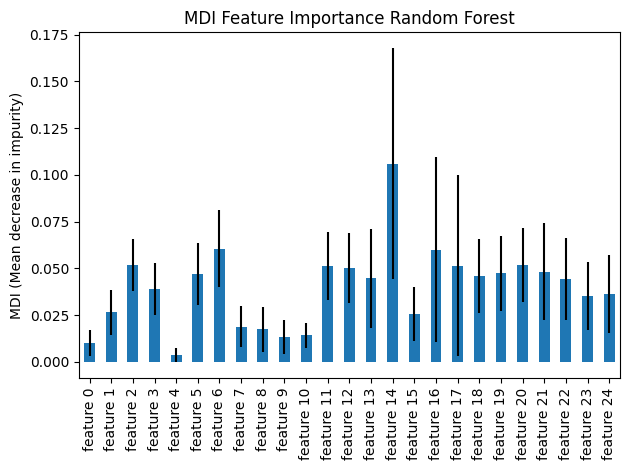

In [853]:
#fitting random forest to assist with feature importance - different to the KNN model earlier 

#naming features 0 to as many exist within the model
feature_names = [f"feature {i}" for i in range(col_X_train.shape[1])]


#including random state in here so that it can be reproduced - arbitrary number is used 
random_forest_classifier = RandomForestClassifier(random_state=14)
random_forest_classifier.fit(col_X_train, col_y_train)

#creating our MDI values using the random forest classifier 
feat_importances = random_forest_classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest_classifier.estimators_], axis=0)

#plotting our MDI for features - this will make it easier to interpret 
forest_importances = pd.Series(feat_importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("MDI Feature Importance Random Forest")
ax.set_ylabel("MDI (Mean decrease in impurity)")
fig.tight_layout()

Feature: 0, Score: 0.06076
Feature: 1, Score: 3.99451
Feature: 2, Score: -0.56907
Feature: 3, Score: -2.79509
Feature: 4, Score: -6.45621
Feature: 5, Score: -1.34673
Feature: 6, Score: 1.28526
Feature: 7, Score: -0.84274
Feature: 8, Score: 0.18345
Feature: 9, Score: 0.19216
Feature: 10, Score: -0.25766
Feature: 11, Score: 2.22089
Feature: 12, Score: -3.45555
Feature: 13, Score: -0.18478
Feature: 14, Score: 0.75667
Feature: 15, Score: 0.52280
Feature: 16, Score: -0.12219
Feature: 17, Score: 0.74349
Feature: 18, Score: -4.26796
Feature: 19, Score: 2.74497
Feature: 20, Score: 1.19642
Feature: 21, Score: 1.04765
Feature: 22, Score: -1.12829
Feature: 23, Score: -1.39405
Feature: 24, Score: 1.48818


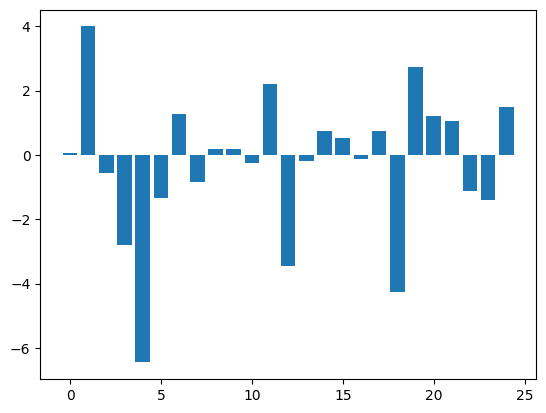

In [854]:
# linear regression feature importance

# our model will be a linear regression model 
model = LinearRegression()
# fit the model
model.fit(col_X_train, col_y_train)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

# Correlation matrix 

In [855]:
#import matplotlib.pyplot as plt

#plt.matshow(colet_final_df.corr())
#plt.show()

# Converting tabular data to images

#https://www.kaggle.com/code/taranmarley/data-images-cnn

#reshape data (we have already scaled it early on)

y_scaler =  preprocessing.StandardScaler().fit(col_y_train.values.reshape(-1, 1))
y_scaled_train = y_scaler.transform(col_y_train.values.reshape(-1, 1))
y_scaled_test = y_scaler.transform(col_y_test.values.reshape(-1, 1))

#conversion to images

model = Tab2Img()
train_images = model.fit_transform(col_X_train, y_scaled_train)
val_images = model.transform(col_X_test)
test_images = model.transform(col_X_test)

fig,ax = plt.subplots(2,5)
for i in range(10):
    nparray = test_images[i].reshape(17,17)
    image = Image.fromarray(nparray * 255)
    ax[i%2][i//2].imshow(image)
fig.show()

# Maching learning models

## SVM

In [856]:
# parameters for the grid search
param_grid = {'C': [0.1, 1, 10, 100, 1000, 10000], 
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]} 

#verbose = 1 to limit the amount of output we see from python   
gridsearch = GridSearchCV(SVC(),  param_grid, refit = True, cv = 10, verbose = 1, scoring='accuracy')
  
# fitting the gridsearch onto the model - using our testing data
gridsearch.fit(col_X_train, col_y_train)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000, 10000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy', verbose=1)

In [857]:
# optimal hyperparameters 
print(gridsearch.best_params_)
  
# best estimators
print(gridsearch.best_estimator_)

#save parameters to input into the model 
svm_colet_hyper = gridsearch.best_params_
best_score = gridsearch.best_score_

{'C': 100, 'gamma': 1, 'kernel': 'poly'}
SVC(C=100, gamma=1, kernel='poly')


In [858]:
#creating the SVC model

# using hyperparmaters identified earlier, we can call these as we saved them, saves a lot of time 
support_vc=SVC(C = svm_colet_hyper['C'], 
gamma=svm_colet_hyper['gamma'], 
kernel=svm_colet_hyper['kernel'], 
random_state = 52) 

# fit to training set
support_vc.fit(col_X_train,col_y_train)

# predictions on test set
y_pred=support_vc.predict(col_X_test)

#accuracy score
acc = accuracy_score(col_y_test,y_pred)

# F1 score

print(classification_report(col_y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.6520    0.7074    0.6786       188
           1     0.5134    0.5134    0.5134       187
           2     0.6497    0.5896    0.6182       173

    accuracy                         0.6040       548
   macro avg     0.6050    0.6035    0.6034       548
weighted avg     0.6039    0.6040    0.6031       548



## CART

In [859]:
decist = DecisionTreeClassifier(random_state=1)
# Createing our grid of hyperparameters - these are what will be searched by the grid 
params_decist = {
'max_depth': [2, 3,4,5, 6,8,10],
'min_samples_leaf': [0.04, 0.06, 0.08, 0.10,0.2,0.4],
'max_features': [0.2, 0.4,0.6, 0.8, 0.10,0.2,0.4]
}
# doing our cross fold search through the grid, checkign by accuracy 
#making use of gridsearch to find the optimal values - note verbose = 1 to limit the amount of output we see from python  
grid_decist = GridSearchCV(estimator=decist,
param_grid=params_decist,
scoring=
'accuracy'
,
cv=10,
n_jobs=-1)

In [860]:
# Fitting the grid to our training data to then find our best hyperparameters 
grid_decist.fit(col_X_train, col_y_train)

#print best hyperparameters as found earlier - these will be used to run our model 
cart_colet_hyper = grid_decist.best_params_
print('Best hyerparameters for CART:', cart_colet_hyper)

Best hyerparameters for CART: {'max_depth': 8, 'max_features': 0.4, 'min_samples_leaf': 0.04}


In [861]:
#create teh final model with our best hyperparameters 

final_model = DecisionTreeClassifier(max_depth = cart_colet_hyper['max_depth'], 
                                     max_features = cart_colet_hyper['max_features'], min_samples_leaf = cart_colet_hyper['min_samples_leaf'], random_state = 50)
final_model.fit(col_X_train, col_y_train)

print(final_model)

#test them 
expected_y  = col_y_test
predicted_y = final_model.predict(col_X_test)
#predicting values from logistic regression and viewing our test score
y_pred = final_model.predict(col_X_test)
print('Accuracy of CART classifier on test set: {:.4f}'.format(final_model.score(col_X_test, col_y_test)))

# F1 score
print(classification_report(col_y_test, y_pred, digits=4))

DecisionTreeClassifier(max_depth=8, max_features=0.4, min_samples_leaf=0.04,
                       random_state=50)
Accuracy of CART classifier on test set: 0.5931
              precision    recall  f1-score   support

           0     0.7202    0.6436    0.6798       188
           1     0.4710    0.6952    0.5616       187
           2     0.7115    0.4277    0.5343       173

    accuracy                         0.5931       548
   macro avg     0.6343    0.5888    0.5919       548
weighted avg     0.6324    0.5931    0.5935       548



## GNB

In [862]:
#set cross validation method
cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=10, 
                                    random_state=52)

In [863]:
#create model and gridsearch using cv method noted above 
model = GaussianNB()
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=model, 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

Data_transformed = PowerTransformer().fit_transform(col_X_test)

gs_NB.fit(col_X_test, col_y_test)

#get best parametesr 
gnb_colet_params = gs_NB.best_params_

Fitting 50 folds for each of 100 candidates, totalling 5000 fits


In [864]:
nb = GaussianNB(var_smoothing = gnb_colet_params['var_smoothing'])
nb.fit(col_X_test, col_y_test)
# make predictions on test set
y_pred=nb.predict(col_X_test)

#confm = confusion_matrix(col_y_test, y_pred)
acc = accuracy_score(col_y_test,y_pred)

print(classification_report(col_y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.4906    0.8351    0.6181       188
           1     0.4487    0.3743    0.4082       187
           2     0.6250    0.2601    0.3673       173

    accuracy                         0.4964       548
   macro avg     0.5214    0.4899    0.4645       548
weighted avg     0.5187    0.4964    0.4673       548



## Light GBM


colet_gbm = lgb.LGBMClassifier(verbose=0)

cgbm_param_grid = {'learning_rate': [0.2, 0.1, 0.05, 0.01, 0.001, 0.001], 'n_estimators': [50, 100, 150, 200, 250, 300, 400, 500], 'max_depth': [1, 3, 5, 7, 10],  }

gs_cgbm = GridSearchCV(estimator=colet_gbm, param_grid=cgbm_param_grid, cv=cv_method)

gs_cgbm.fit(col_X_train, col_y_train)

gbm_colet_params = gs_cgbm.best_params_

In [865]:
#Use default parameters 

colet_gbm = lgb.LGBMClassifier(learning_rate = gbm_colet_params['learning_rate'], max_depth = gbm_colet_params['max_depth'], n_estimators = gbm_colet_params['n_estimators'], verbose=0)
colet_gbm.fit(col_X_train, col_y_train, eval_set=[(col_X_train, col_y_train),(col_X_test, col_y_test)])

## XGBoost

In [866]:
#XGBoost 

In [867]:
import xgboost as xgbc

#https://www.kaggle.com/code/emmanuelfwerr/xgboost-multi-class-classification#XGBoost-Classifier
#https://xgboost.readthedocs.io/en/stable/parameter.html

xgb = xgbc.XGBClassifier(objective = 'multi:softmax', #want a class output, softmax is the most appropriate
           num_class = 3, #we already know we have 3 classes
           #early_stopping_rounds=10, #if nothing happens after 10 rounds... stop
           eval_metric=['auc'], #AUC for consistency with TabNet, perhaps RMSE and multiclass logloss? 
           seed = 16 #set seed for consistency 
          )

xgb.fit(col_X_test, col_y_test)
y_pred = xgb.predict(col_X_test)

acc = accuracy_score(col_y_test,y_pred)

print(classification_report(col_y_test, y_pred, digits=4))


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       188
           1     1.0000    0.9893    0.9946       187
           2     0.9886    1.0000    0.9943       173

    accuracy                         0.9964       548
   macro avg     0.9962    0.9964    0.9963       548
weighted avg     0.9964    0.9964    0.9964       548



## KNN

In [868]:
#KNN

#COLET AUTHORS FOUND THIS PREDICTED REALLY WELL, IT SHOULD BE INCLUDED... 

In [869]:
knn = KNeighborsClassifier(n_neighbors = 3)

knn.fit(col_X_test, col_y_test)
y_pred=knn.predict(col_X_test)

acc = accuracy_score(col_y_test,y_pred)

print(classification_report(col_y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7269    0.8777    0.7952       188
           1     0.7483    0.5882    0.6587       187
           2     0.7644    0.7688    0.7666       173

    accuracy                         0.7445       548
   macro avg     0.7465    0.7449    0.7401       548
weighted avg     0.7460    0.7445    0.7396       548



# Deep Learning Approach

####################################################

# REMEMBER TO UPDATE THE INPUT SHAPE IF REMOVING FEATURES! WILL NO LONGER BE 25

In [887]:
####################################################

# TabNet

# parameters 
classifier = TabNetClassifier(
    seed=42,
    optimizer_params=dict(lr=0.01),  # Modify the learning rate here (lr=0.01 as an example)
    scheduler_params={"step_size": 10, "gamma": 0.9},  # Learning rate scheduler parameters
    verbose=1  # Set verbosity level
)

In [870]:
classifier = TabNetClassifier(seed=42, verbose = 0)
classifier.fit(X_train=col_X_train, y_train=col_y_train,
               patience=5,max_epochs=10000,
               eval_metric=['auc'])

In [871]:
#testing below, have added in digits = 4... can remove if it failx

y_pred=classifier.predict(col_X_test)
print(classification_report(col_y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8051    0.8351    0.8198       188
           1     0.6329    0.7005    0.6650       187
           2     0.7466    0.6301    0.6834       173

    accuracy                         0.7245       548
   macro avg     0.7282    0.7219    0.7227       548
weighted avg     0.7279    0.7245    0.7239       548



# Self normalizing neural network

In [872]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#SNN model
model = Sequential()
model.add(Dense(units=128, activation="selu", kernel_initializer="lecun_normal", input_shape=(25,))) # col_X_train.shape[1:]selu is a self-normalization method, lecun works well with it 
model.add(Dense(units=32, activation="selu", kernel_initializer="lecun_normal")) #selu is a self-normalization method, lecun works well with it
model.add(Dense(units=32, activation="selu", kernel_initializer="lecun_normal")) #selu is a self-normalization method, lecun works well with it
model.add(Dense(units=3, activation="softmax")) #softmax because we have a multiclass (not a multilabel) problem, use sigmoid for binary in the next model, lecun works well with it

model.compile(
        optimizer="adam", #adam is a good all-rounder 
        loss="categorical_crossentropy", #categorical as we have a multiclass problem 
        metrics=["AUC"] #AUC for consistency 

    )

model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 128)               3328      
                                                                 
 dense_73 (Dense)            (None, 32)                4128      
                                                                 
 dense_74 (Dense)            (None, 32)                1056      
                                                                 
 dense_75 (Dense)            (None, 3)                 99        
                                                                 
Total params: 8611 (33.64 KB)
Trainable params: 8611 (33.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [873]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.8,
    patience=10,
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=60,
    restore_best_weights=True
)

callbacks = [reduce_lr, early_stop]

In [874]:
#reshape X train data 

X_train = col_X_train.reshape(col_X_train.shape[0], col_X_train.shape[1], 1)
X_test = col_X_test.reshape(col_X_test.shape[0], col_X_test.shape[1], 1)

In [875]:
# One-hot encode the adjusted target labels

from tensorflow.keras.utils import to_categorical

num_classes = 3
col_y_train_encoded = to_categorical(col_y_train, num_classes=num_classes)
col_y_test_encoded = to_categorical(col_y_test, num_classes=num_classes)

In [876]:
col_y_train_encoded

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [877]:
model.fit(
        X_train,
        col_y_train_encoded,
        validation_data=(col_X_test, col_y_test_encoded),
        epochs=10000,
        batch_size=685,
        callbacks=[reduce_lr, early_stop],
        verbose=False,
    
    )

In [878]:
#https://stackoverflow.com/questions/48987959/classification-metrics-cant-handle-a-mix-of-continuous-multioutput-and-multi-la
#input to GPT
#y_pred=model.predict(X_test)
#y_pred=np.argmax(y_pred, axis=1)
#print(classification_report(col_y_test_encoded, y_pred, digits=4))

#ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

#GPT response
#code below: 


from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer

# Assuming y_pred=model.predict(X_test) has been defined earlier
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Assuming col_y_test_encoded, X_test, and model are defined earlier

# Convert col_y_test_encoded to multiclass format using LabelBinarizer
lb = LabelBinarizer()
col_y_test_multiclass = lb.fit_transform(col_y_test_encoded)
col_y_test_multiclass = np.argmax(col_y_test_multiclass, axis=1)

# Print the classification report
print(classification_report(col_y_test_multiclass, y_pred, digits=4))

18/18 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0     0.6985    0.7394    0.7183       188
           1     0.4906    0.4171    0.4509       187
           2     0.6105    0.6705    0.6391       173

    accuracy                         0.6077       548
   macro avg     0.5999    0.6090    0.6028       548
weighted avg     0.5998    0.6077    0.6021       548



# Multilayer Perceptron 

In [879]:
#using code from Gayathri 
from tensorflow.python.keras import regularizers

def mlp_model():
    # Set the input shape
    input_shape = (25,)
    print(f'Feature shape: {input_shape}')
    print("In simple model ..........")
    mlp = Sequential()
    mlp.add(Dense(64, activation='relu', input_shape = input_shape,kernel_initializer='uniform',kernel_regularizer = regularizers.l2(0.001)))
    mlp.add(Dense(32, kernel_initializer = 'uniform', activation='relu',kernel_regularizer = regularizers.l2(0.001)))
    mlp.add(Dense(16,  kernel_initializer = 'uniform', activation='relu',kernel_regularizer = regularizers.l2(0.001)))
    #mlp.add(Dense(8, kernel_initializer = 'uniform', activation='relu',kernel_regularizer = regularizers.l2(0.001)))
    mlp.add(Dense(num_classes, activation='softmax'))    
    #mlp.summary()
    #opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)#Adam(lr=5e-5)
    #opt = SGD(lr=0.01, momentum=0.9)
    mlp.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['AUC'])
    print('compile done')
    return mlp

In [880]:
model = mlp_model()

Feature shape: (25,)
In simple model ..........
compile done


In [881]:
model.fit(
        X_train,
        col_y_train_encoded,
        validation_data=(col_X_test, col_y_test_encoded),
        epochs=10000,
        batch_size=685,
        callbacks=[reduce_lr, early_stop],
        verbose=False,
    
    )

In [882]:
# Assuming y_pred=model.predict(X_test) has been defined earlier
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Print the classification report
print(classification_report(col_y_test_multiclass, y_pred, digits=4))

18/18 [==============================] - 0s 913us/step
              precision    recall  f1-score   support

           0     0.6777    0.7606    0.7168       188
           1     0.5165    0.2513    0.3381       187
           2     0.5691    0.8092    0.6683       173

    accuracy                         0.6022       548
   macro avg     0.5878    0.6071    0.5744       548
weighted avg     0.5884    0.6022    0.5723       548



# 1D CNN

In [883]:
#using code from Gayathri 
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dropout
#from tensorflow.keras.layers import 


def cnn_1d_model():
    
    model = Sequential()
    #Sintput_shape=(x_train.shape[1], 1)
    model.add(Conv1D(128, kernel_size=3,padding = 'same',activation='relu', input_shape=(25,1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Flatten())
    model.add(Dense(64, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    model.summary()
        
#    #sgd = SGD(lr = 1e-9, momentum = 0.9, decay = 0, nesterov = False)
#    opt = Adadelta(lr=1e-7)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['AUC'])
    
#    model.summary()
    
    return model

In [884]:
model = cnn_1d_model()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 25, 128)           512       
                                                                 
 batch_normalization_12 (Ba  (None, 25, 128)           512       
 tchNormalization)                                               
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 12, 128)           0         
 ng1D)                                                           
                                                                 
 conv1d_13 (Conv1D)          (None, 12, 128)           49280     
                                                                 
 batch_normalization_13 (Ba  (None, 12, 128)           512       
 tchNormalization)                                               
                                                     

In [885]:
model.fit(
        X_train,
        col_y_train_encoded,
        validation_data=(col_X_test, col_y_test_encoded),
        epochs=10000,
        batch_size=685,
        callbacks=[reduce_lr, early_stop],
        verbose=False,
    
    )

In [886]:
# Assuming y_pred=model.predict(X_test) has been defined earlier
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Print the classification report
print(classification_report(col_y_test_multiclass, y_pred, digits=4))

18/18 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0     0.6400    0.1702    0.2689       188
           1     0.5000    0.0214    0.0410       187
           2     0.3449    0.9769    0.5098       173

    accuracy                         0.3741       548
   macro avg     0.4950    0.3895    0.2732       548
weighted avg     0.4991    0.3741    0.2672       548

